In [1]:
import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
import multigrate as mtg
import scanpy as sc
import numpy as np
import pandas as pd

Global seed set to 0


In [2]:
sc.set_figure_params(dpi_save=300)

In [3]:
rna = sc.read('../../../data/neurips-multiome/rna_hvg_batch.h5ad')
rna

AnnData object with n_obs × n_vars = 69249 × 4000
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'ATAC_gene_activity_var_names', 'Site_colors', 'batch_colors', 'cell_type_colors', 'dataset_id', 'genome', 'hvg', 'log1p', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap', 'X_umap'
    layers: 'counts'

In [4]:
atac = sc.read('../../../data/neurips-multiome/atac_hvf.h5ad')
atac

AnnData object with n_obs × n_vars = 69249 × 40002
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'cell_type_l2', 'cell_type_l1', 'cell_type_l3', 'assay'
    var: 'feature_types', 'gene_id', 'n_cells', 'prop_shared_cells', 'variability_score'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'binary', 'counts', 'cpm', 'tf-idf', 'tf-idf-binary', 'tf-idf-counts'

In [5]:
adata = mtg.data.organize_multiome_anndatas(
    adatas = [[rna], [atac]],
    groups = [[0], [0]],
    layers = [['counts'], ['cpm']],
    modality_lengths=[4000, 40002],
)
adata

AnnData object with n_obs × n_vars = 69249 × 44002
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'group'
    var: 'feature_types', 'gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'n_cells', 'prop_shared_cells', 'variability_score'
    layers: 'counts', 'binary', 'cpm', 'tf-idf', 'tf-idf-binary', 'tf-idf-counts'

In [6]:
mtg.model.MultiVAE.setup_anndata(
    adata,
    categorical_covariate_keys=['batch'],
    rna_indices_end=4000,
)

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Successfully registered anndata object containing 69249 cells, 44002 vars, 1        
         batches, 1 labels, and 0 proteins. Also registered 1 extra categorical covariates   
         and 1 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


In [7]:
model = mtg.model.MultiVAE(
    adata, 
    modality_lengths=[4000, 40002],
    losses=['nb', 'mse'],
    loss_coefs={'kl': 1e-5,
               'integ': 0,
               },
    z_dim=16,
    cond_dim=16,
    dropout=0.2,
    n_layers_encoders=[2, 2],
    n_layers_decoders=[2, 2],
)

In [8]:
model.train(max_epochs=200, lr=1e-3, batch_size=256)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 1/200:   0%|          | 1/200 [00:26<1:26:07, 25.97s/it, loss=4.18e+04, v_num=1]

Metric elbo_validation improved. New best score: 42390.172


Epoch 2/200:   1%|          | 2/200 [00:44<1:10:26, 21.35s/it, loss=4.3e+04, v_num=1] 

Metric elbo_validation improved by 281.738 >= min_delta = 0.0. New best score: 42108.434


Epoch 3/200:   2%|▏         | 3/200 [01:02<1:05:35, 19.98s/it, loss=4.23e+04, v_num=1]

Metric elbo_validation improved by 173.672 >= min_delta = 0.0. New best score: 41934.762


Epoch 4/200:   2%|▏         | 4/200 [01:21<1:03:49, 19.54s/it, loss=4.17e+04, v_num=1]

Metric elbo_validation improved by 43.086 >= min_delta = 0.0. New best score: 41891.676


Epoch 5/200:   2%|▎         | 5/200 [01:39<1:01:58, 19.07s/it, loss=4.29e+04, v_num=1]

Metric elbo_validation improved by 31.023 >= min_delta = 0.0. New best score: 41860.652


Epoch 6/200:   3%|▎         | 6/200 [01:57<1:00:08, 18.60s/it, loss=4.1e+04, v_num=1] 

Metric elbo_validation improved by 19.996 >= min_delta = 0.0. New best score: 41840.656


Epoch 7/200:   4%|▎         | 7/200 [02:16<1:01:00, 18.97s/it, loss=4.05e+04, v_num=1]

Metric elbo_validation improved by 13.496 >= min_delta = 0.0. New best score: 41827.160


Epoch 8/200:   4%|▍         | 8/200 [02:35<1:00:24, 18.88s/it, loss=4.21e+04, v_num=1]

Metric elbo_validation improved by 5.230 >= min_delta = 0.0. New best score: 41821.930


Epoch 9/200:   4%|▍         | 9/200 [02:53<59:20, 18.64s/it, loss=4.19e+04, v_num=1]  

Metric elbo_validation improved by 8.770 >= min_delta = 0.0. New best score: 41813.160


Epoch 10/200:   5%|▌         | 10/200 [03:11<58:27, 18.46s/it, loss=3.98e+04, v_num=1]

Metric elbo_validation improved by 6.004 >= min_delta = 0.0. New best score: 41807.156


Epoch 11/200:   6%|▌         | 11/200 [03:30<58:25, 18.55s/it, loss=4.16e+04, v_num=1]

Metric elbo_validation improved by 3.289 >= min_delta = 0.0. New best score: 41803.867


Epoch 12/200:   6%|▌         | 12/200 [03:50<58:58, 18.82s/it, loss=4.11e+04, v_num=1]

Metric elbo_validation improved by 3.391 >= min_delta = 0.0. New best score: 41800.477


Epoch 13/200:   6%|▋         | 13/200 [04:07<57:43, 18.52s/it, loss=4.07e+04, v_num=1]

Metric elbo_validation improved by 2.586 >= min_delta = 0.0. New best score: 41797.891


Epoch 14/200:   7%|▋         | 14/200 [04:25<56:47, 18.32s/it, loss=4.22e+04, v_num=1]

Metric elbo_validation improved by 0.883 >= min_delta = 0.0. New best score: 41797.008


Epoch 15/200:   8%|▊         | 15/200 [04:45<57:35, 18.68s/it, loss=4.17e+04, v_num=1]

Metric elbo_validation improved by 4.707 >= min_delta = 0.0. New best score: 41792.301


Epoch 16/200:   8%|▊         | 16/200 [05:04<58:10, 18.97s/it, loss=4.12e+04, v_num=1]

Metric elbo_validation improved by 2.621 >= min_delta = 0.0. New best score: 41789.680


Epoch 18/200:   9%|▉         | 18/200 [05:42<57:36, 18.99s/it, loss=4.1e+04, v_num=1] 

Metric elbo_validation improved by 1.098 >= min_delta = 0.0. New best score: 41788.582


Epoch 19/200:  10%|▉         | 19/200 [06:01<57:07, 18.94s/it, loss=4.2e+04, v_num=1]

Metric elbo_validation improved by 1.957 >= min_delta = 0.0. New best score: 41786.625


Epoch 22/200:  11%|█         | 22/200 [06:56<55:14, 18.62s/it, loss=3.93e+04, v_num=1]

Metric elbo_validation improved by 1.688 >= min_delta = 0.0. New best score: 41784.938


Epoch 26/200:  13%|█▎        | 26/200 [08:12<54:33, 18.81s/it, loss=4.21e+04, v_num=1]

Metric elbo_validation improved by 0.375 >= min_delta = 0.0. New best score: 41784.562


Epoch 27/200:  14%|█▎        | 27/200 [08:31<54:45, 18.99s/it, loss=4.05e+04, v_num=1]

Metric elbo_validation improved by 0.496 >= min_delta = 0.0. New best score: 41784.066


Epoch 28/200:  14%|█▍        | 28/200 [08:52<55:22, 19.32s/it, loss=4.05e+04, v_num=1]

Metric elbo_validation improved by 0.566 >= min_delta = 0.0. New best score: 41783.500


Epoch 29/200:  14%|█▍        | 29/200 [09:10<54:24, 19.09s/it, loss=4.15e+04, v_num=1]

Metric elbo_validation improved by 0.254 >= min_delta = 0.0. New best score: 41783.246


Epoch 30/200:  15%|█▌        | 30/200 [09:29<54:11, 19.13s/it, loss=4.1e+04, v_num=1] 

Metric elbo_validation improved by 0.098 >= min_delta = 0.0. New best score: 41783.148


Epoch 31/200:  16%|█▌        | 31/200 [09:49<54:02, 19.18s/it, loss=4.08e+04, v_num=1]

Metric elbo_validation improved by 0.582 >= min_delta = 0.0. New best score: 41782.566


Epoch 32/200:  16%|█▌        | 32/200 [10:08<53:34, 19.14s/it, loss=4.11e+04, v_num=1]

Metric elbo_validation improved by 0.621 >= min_delta = 0.0. New best score: 41781.945


Epoch 38/200:  19%|█▉        | 38/200 [12:01<50:35, 18.74s/it, loss=4.27e+04, v_num=1]

Metric elbo_validation improved by 0.023 >= min_delta = 0.0. New best score: 41781.922


Epoch 83/200:  42%|████▏     | 83/200 [25:56<36:16, 18.60s/it, loss=4.08e+04, v_num=1]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: 41781.922. Signaling Trainer to stop.


Epoch 83/200:  42%|████▏     | 83/200 [25:58<36:36, 18.77s/it, loss=4.08e+04, v_num=1]


In [9]:
model.get_latent_representation(batch_size=256)
adata

AnnData object with n_obs × n_vars = 69249 × 44002
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'group', 'size_factors', '_scvi_batch', '_scvi_labels'
    var: 'feature_types', 'gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'n_cells', 'prop_shared_cells', 'variability_score'
    uns: '_scvi'
    obsm: '_scvi_extra_categoricals', '_scvi_extra_continuous', 'latent'
    layers: 'counts', 'binary', 'cpm', 'tf-idf', 'tf-idf-binary', 'tf-idf-counts'

In [10]:
sc.pp.neighbors(adata, use_rep='latent')
sc.tl.umap(adata)

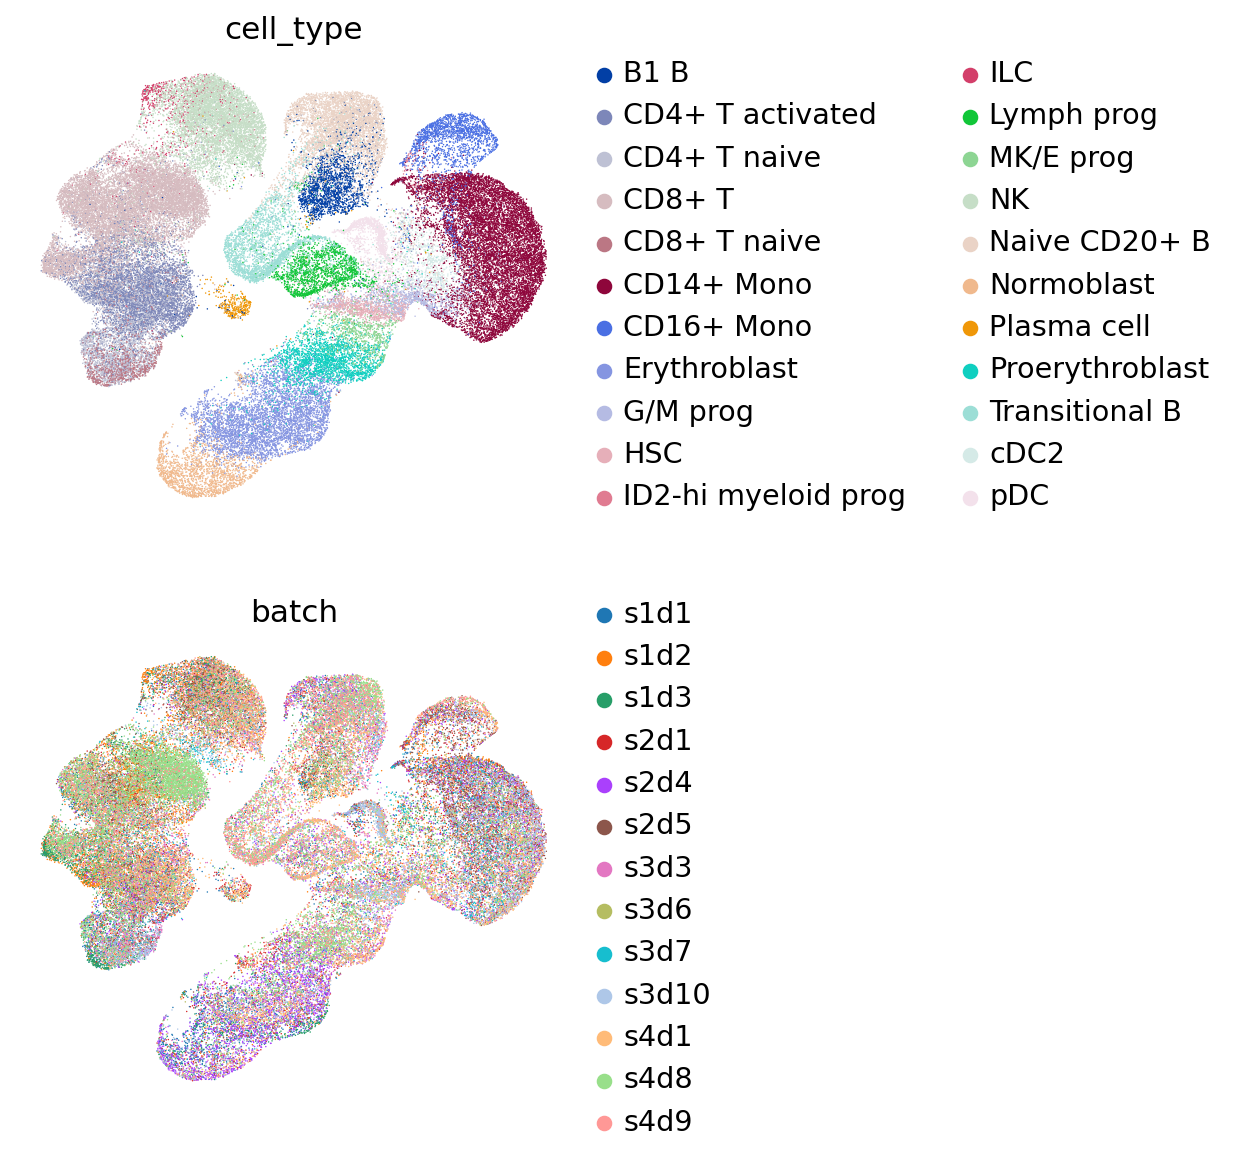

In [11]:
sc.pl.umap(adata, color=['cell_type', 'batch'], ncols=1, frameon=False, save='_multigrate_neurips_multiome.png')

In [12]:
adata_ = sc.AnnData(adata.X)
adata_.obs = adata.obs.copy()
adata_.uns = adata.uns.copy()
adata_.obsm = adata.obsm.copy()
adata_.obsp = adata.obsp.copy()

In [13]:
adata_.write('multigrate_neurips_multiome.h5ad')